In [1]:
""""Now in last section we exprimented with conditional workflows in the Langgraph.But this conitional workflow was not LLM Powered.
Now we will be devolping LLM Powered conditional workflows.
So what actually the problem statment is .We will get review from the user as an input.Thne we will find out that to which category
this review belongs to it may either belong to positive category and negative category.If the review belongs to positive category then we will
generate the positive response.But if the review belongs to negative category then we will not directly generate the negative response.
we will diagonise of this negative response.Like getting issue_type,tone,urgency from the negative review then i will be using all of these
to generate the final response which will actually solve the problem of user.
now we have understood what actually we need to do so let us do it.
"""

'"Now in last section we exprimented with conditional workflows in the Langgraph.But this conitional workflow was not LLM Powered.\nNow we will be devolping LLM Powered conditional workflows.\nSo what actually the problem statment is .We will get review from the user as an input.Thne we will find out that to which category\nthis review belongs to it may either belong to positive category and negative category.If the review belongs to positive category then we will\ngenerate the positive response.But if the review belongs to negative category then we will not directly generate the negative response.\nwe will diagonise of this negative response.Like getting issue_type,tone,urgency from the negative review then i will be using all of these\nto generate the final response which will actually solve the problem of user.\nnow we have understood what actually we need to do so let us do it.\n'

In [2]:
## let us start coding of this project
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Literal,List
from pydantic import BaseModel,Field
load_dotenv() ## activating up all the secret variables

True

In [11]:
class State(TypedDict):
    review:str
    sentiment:str
    response:str
    issue_type:str
    tone:str
    urgency:str

In [4]:
class Sentiment(BaseModel):
    sentiment:Literal["positive","negative"] = Field(description="sentiment of the user review either positive or negative")

In [5]:
class Diagnosis(BaseModel):
    issue_type:Literal["UI","DataBase","Loading time","Processing Time"] = Field(description="The issue ,user is facing in the website")
    tone:Literal["soft","rude","normal"] = Field(description="The tone of the user in the review")
    urgency:Literal["High","Medium","Low"] = Field(description="The urgency based on the user review")

In [6]:
llm = ChatOpenAI()
structured_llm_1 = llm.with_structured_output(Sentiment)
structured_llm_2 = llm.with_structured_output(Diagnosis)

d:\Langgraph_revision\venv\lib\site-packages\langchain_openai\chat_models\base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [7]:
structured_llm_1.invoke("This product is very good")
## the structured llm is working fine

Sentiment(sentiment='positive')

In [10]:
structured_llm_2.invoke("The UX of the website is very bad .I want this in better form as soon as possible if it takes time then no problem")


Diagnosis(issue_type='UI', tone='rude', urgency='High')

In [15]:
## creating first component which will fetch the sentiment of the user review
def fetch_sentiment(state:State) ->dict:
    review = state["review"]

    prompt = f""" For the given user review \n\n {review} analyze it then find out that it belongs to positive category or negative category.
    return 'positive' if the user belongs to positive category 
     return 'negative' if the user belongs to negative category 
                            """
    sentiment = structured_llm_1.invoke(review).sentiment
    return {'sentiment':sentiment}

In [14]:
def router(state:State) ->str:
    sentiment = state["sentiment"]
    if sentiment == "positive":
        return "get_positive_response"
    else:
        return "get_diagnosis"

In [ ]:
def get_positive_response(state:State) ->dict:
    review = state["review"]
    prompt = f"""for the given user positive review \n {review}  .Write a thankfull response to user.  
                          """
    response = llm.invoke(prompt).content
    return {'response':response}

In [17]:
def get_diagnosis(state:State) ->dict:
    review = state["review"]

    prompt = f""" for the given user negative review\n {review}.
    Fetch out these important details issue type,tone and urgency
                """
    response = structured_llm_2.invoke(prompt)
    issue_type = response.issue_type
    tone = response.tone
    urgency = response.urgency

    return {"issue_type":issue_type,"tone":tone,"urgency":urgency}

In [18]:
def get_negative_response(state:State) ->dict:
    review = state["review"]
    issue_type = state["issue_type"]
    tone = state["tone"]
    urgency = state["urgency"]

    prompt = f""" for the given negative review \n {review} by the user.It has been found user is facing the issue {issue_type},
    the tone of the user is found {tone} and urgency is {urgency} Give the good response to user based on above data such that user will get 
    satisfied that we will solve the problem faced by user.
                        """
    response = llm.invoke(prompt).content
    return {'response':response}

In [23]:
## till here we have created all the components of the graph
## now i will be joining all the components in the graph
graph = StateGraph(State)
graph.add_node("fetch_sentiment",fetch_sentiment)
graph.add_node("get_positive_response",get_positive_response)
graph.add_node("get_diagnosis",get_diagnosis)
graph.add_node("get_negative_response",get_negative_response)

## defined all the nodes in the graph 
## now joining all the nodes of the graph
## using my logic
graph.add_edge(START,"fetch_sentiment")
graph.add_conditional_edges("fetch_sentiment",router,{"get_positive_response":"get_positive_response","get_diagnosis":"get_diagnosis"})
graph.add_edge("get_diagnosis","get_negative_response")
graph.add_edge("get_negative_response",END)
graph.add_edge("get_positive_response",END)

workflow = graph.compile()

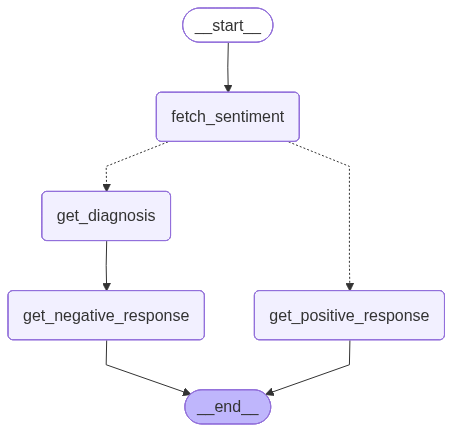

In [24]:
workflow

In [26]:
initial_state = {"review":"The UX of the website is very good .I want this more better form as soon as possible if it takes time then no problem"}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': 'The UX of the website is very good .I want this more better form as soon as possible if it takes time then no problem', 'sentiment': 'positive', 'response': 'Thank you so much for your positive review! We are glad to hear that you are enjoying the UX of our website. We are constantly working to improve and make it even better, so your feedback is much appreciated. We will do our best to make the necessary enhancements as quickly as possible. Thank you for your support!'}
